In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd './gdrive/My Drive/263_hw4/'
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/263_hw4
Homework_4.pdf    osrm_test.csv     train.csv
Midterm.ipynb     osrm_train.csv    Travel_Time_Prediction.ipynb
Midterm-nn.ipynb  python-osrm/      xgboost/
osrm_10000.ipynb  requirements.txt  yingying_submission_3600.csv
osrm.egg-info/    submission.csv    yingying_submission_5000.csv
osrm.ipynb        test.csv          yingying_submission.csv


In [0]:
!git clone --recursive https://github.com/dmlc/xgboost
%cd xgboost
!mkdir build
%cd build
!cmake .. -DUSE_CUDA=ON
!make -j4

In [0]:
%cd ..
%cd python-package
!python3 setup.py develop --user
%cd ..

In [0]:
%cd ..
!pip3 install -r requirements.txt

In [0]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

warnings.filterwarnings('ignore')

In [0]:
plt.rcParams['figure.figsize'] = [8, 5]

# Data understanding


In [0]:
np.random.seed(2333)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train_old = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./submission.csv')

In [249]:
print('There are {} training rows and {} test rows.'.format(train_old.shape[0], test.shape[0]))
print('There are {} training columns and {} test columns.'.format(train_old.shape[1], test.shape[1]))
train_old.head(2)

There are 146001 training rows and 30000 test rows.
There are 7 training columns and 6 test columns.


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0


In [250]:
# check if there are missing values, if so remove the entries
print("training set:", train_old.isnull().sum())
print("test set:", test.isnull().sum())

train_nonull = train_old.dropna(how='any', inplace=False)
print("updated:", train_nonull.isnull().sum())

training set: row_id         0
start_lng    400
start_lat      0
end_lng        0
end_lat      600
datetime       0
duration       0
dtype: int64
test set: row_id       0
start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
dtype: int64
updated: row_id       0
start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
duration     0
dtype: int64


In [0]:
# Add OSRM Features
train_street_info = pd.read_csv('./osrm_train.csv',
                               usecols=['row_id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('./osrm_test.csv',
                               usecols=['row_id', 'total_distance', 'total_travel_time', 'number_of_steps'])

train_nonull = train_nonull.merge(train_street_info, how='left', on=['row_id'])
test = test.merge(test_street_info, how='left', on=['row_id'])

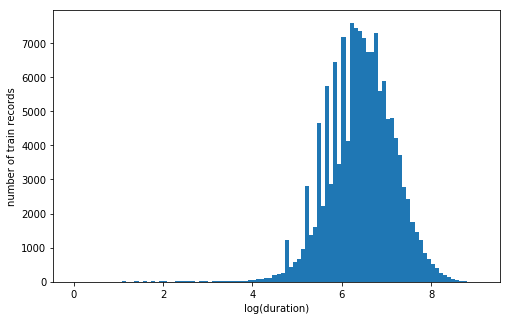

In [258]:
# Rmemove trips that are unreseaonably too long or too short,
# based on total_travel_time calculated in OSRM
train_nonull['diff'] = train_nonull['duration'] - train_nonull['total_travel_time']
train_diff = train_nonull.loc[(train_nonull['diff'] > -2000) & (train_nonull['diff'] < 6600)]

train_nonzero = train_diff.loc[~((train_diff['duration'] <= 4) & (train_diff['diff'] < -100))]
train_nonzero['log_duration'] = np.log(train_nonzero['duration'].values + 1)

plt.hist(train_nonzero['log_duration'].values, bins=100)
plt.xlabel('log(duration)')
plt.ylabel('number of train records')
plt.show()

In [259]:
train = train_nonzero
print(train.shape, test.shape)

(139971, 12)


(30000, 9)

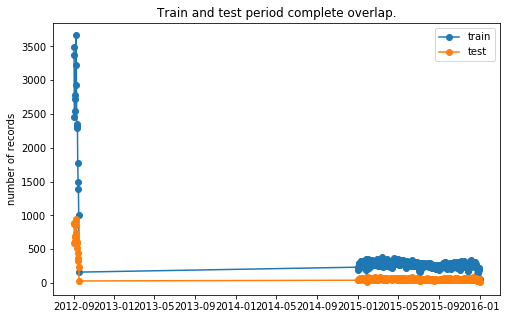

In [260]:
train['datetime'] = pd.to_datetime(train.datetime)
test['datetime'] = pd.to_datetime(test.datetime)
train.loc[:, 'date'] = train['datetime'].dt.date
test.loc[:, 'date'] = test['datetime'].dt.date

# Plot datetime
plt.plot(train.groupby('date').count()[['row_id']], 'o-', label='train')
plt.plot(test.groupby('date').count()[['row_id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

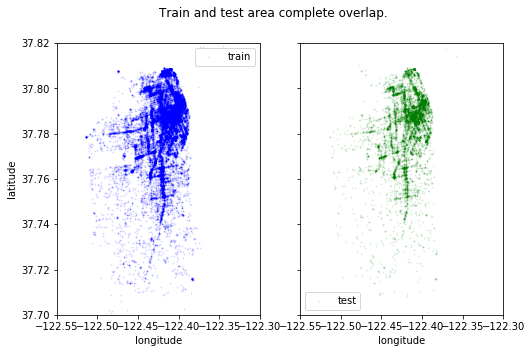

In [263]:
# Found two major geo locations, plot them out 
# SF
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['start_lng'].values[:], train['start_lat'].values[:],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['start_lng'].values[:], test['start_lat'].values[:],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim((37.70, 37.82))
plt.xlim((-122.55, -122.3))
plt.show()

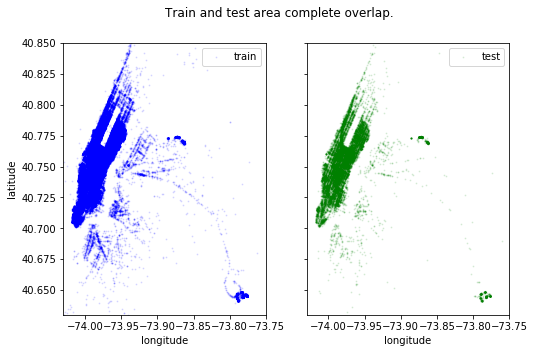

In [266]:
# NY
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['start_lng'].values[:], train['start_lat'].values[:],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['start_lng'].values[:], test['start_lat'].values[:],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

# Feature Extraction

In [0]:
# use PCA to transform longitude and latitude coordinates
coords = np.vstack((train[['start_lat', 'start_lng']].values,
                    train[['end_lat', 'end_lng']].values,
                    test[['start_lat', 'start_lng']].values,
                    test[['end_lat', 'end_lng']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['start_lat', 'start_lng']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['start_lat', 'start_lng']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['end_lat', 'end_lng']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['end_lat', 'end_lng']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['start_lat', 'start_lng']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['start_lat', 'start_lng']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['end_lat', 'end_lng']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['end_lat', 'end_lng']])[:, 1]

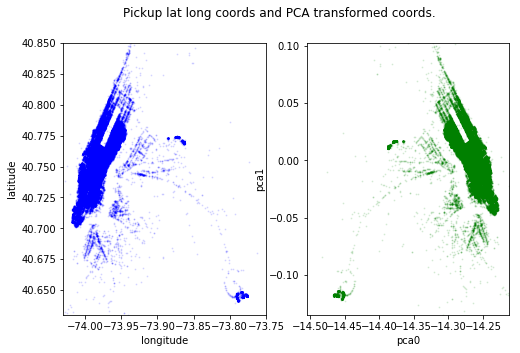

In [272]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['start_lng'].values[:N], train['start_lat'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

In [0]:
# Distance Features
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['start_lat'].values, train['start_lng'].values, train['end_lat'].values, train['end_lng'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['start_lat'].values, train['start_lng'].values, train['end_lat'].values, train['end_lng'].values)
train.loc[:, 'direction'] = bearing_array(train['start_lat'].values, train['start_lng'].values, train['end_lat'].values, train['end_lng'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['start_lat'].values, test['start_lng'].values, test['end_lat'].values, test['end_lng'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['start_lat'].values, test['start_lng'].values, test['end_lat'].values, test['end_lng'].values)
test.loc[:, 'direction'] = bearing_array(test['start_lat'].values, test['start_lng'].values, test['end_lat'].values, test['end_lng'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['start_lat'].values + train['end_lat'].values) / 2
train.loc[:, 'center_longitude'] = (train['start_lng'].values + train['end_lng'].values) / 2
test.loc[:, 'center_latitude'] = (test['start_lat'].values + test['end_lat'].values) / 2
test.loc[:, 'center_longitude'] = (test['start_lng'].values + test['end_lng'].values) / 2

In [0]:
# Datetime features
train.loc[:, 'pickup_weekday'] = train['datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['datetime'] - train['datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['datetime'] - train['datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

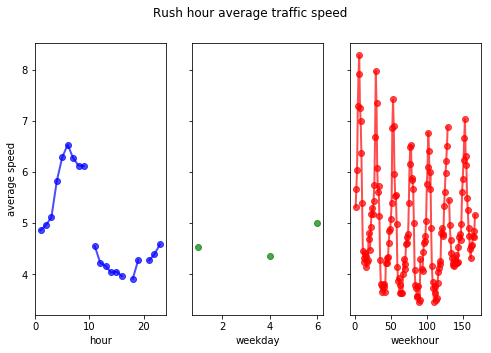

In [298]:
# Speed
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['duration']
train.loc[:, 'fastest_speed'] = 1000 * train['total_distance'] / train['total_travel_time']
test.loc[:, 'fastest_speed'] = 1000 * test['total_distance'] / test['total_travel_time']


fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

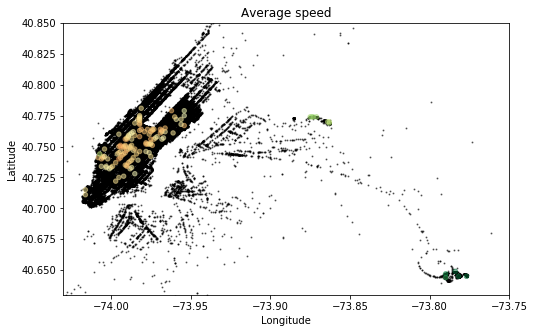

In [299]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['start_lat'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['start_lng'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['row_id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['row_id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.start_lng.values[:N], train.start_lat.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['start_lat'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['start_lng'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['start_lat'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['start_lng'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

In [0]:
# Clustering
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [0]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['start_lat', 'start_lng']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['end_lat', 'end_lng']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['start_lat', 'start_lng']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['end_lat', 'end_lng']])
t1 = dt.datetime.now()
# print('Time till clustering: %i seconds' % (t1 - t0).seconds)

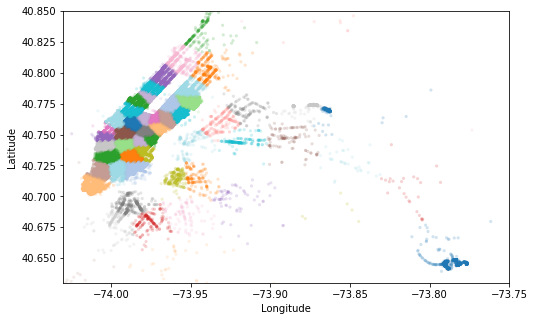

In [281]:
# Visualization of NY clustering
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.start_lng.values[:N], train.start_lat.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

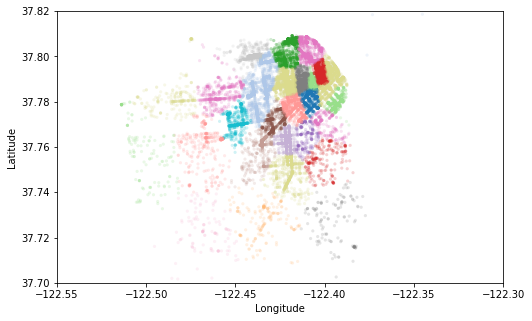

In [282]:
# Visualization of SF clustering
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.start_lng.values[:N], train.start_lat.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim((-122.55, -122.3))
ax.set_ylim((37.70, 37.82))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [0]:
for gby_col in ['pickup_hour', 'date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['row_id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['row_id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [0]:
group_freq = '60min'
df_all = pd.concat((train, test))[['row_id', 'datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['datetime'].dt.round(group_freq)

# Count trips over 60min
# df_counts = df_all.set_index('datetime')[['row_id']].sort_index()
# df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['row_id']
# train = train.merge(df_counts, on='row_id', how='left')
# test = test.merge(df_counts, on='row_id', how='left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'row_id': 'count'}) \
    .reset_index().set_index('datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'datetime': 'pickup_datetime_group', 'row_id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

In [0]:
# Airports: SFO, JFK LGA
sfo_coord = [37.615223, -122.389977]
jfk_coord = [40.639722, -73.778889]
la_guardia_coord = [40.77725, -73.872611]

train.loc[:, 'JFK_pick'] = haversine_array(jfk_coord[0], jfk_coord[1], train['end_lat'].values, train['end_lng'].values)
train.loc[:, 'LGA_pick'] = haversine_array(la_guardia_coord[0], la_guardia_coord[1], train['end_lat'].values, train['end_lng'].values)
train.loc[:, 'SFO_pick'] = haversine_array(sfo_coord[0], sfo_coord[1], train['end_lat'].values, train['end_lng'].values)

train.loc[:, 'JFK_drop'] = haversine_array(train['start_lat'].values, train['start_lng'].values, jfk_coord[0], jfk_coord[1])
train.loc[:, 'LGA_drop'] = haversine_array(train['start_lat'].values, train['start_lng'].values, la_guardia_coord[0], la_guardia_coord[1])
train.loc[:, 'SFO_drop'] = haversine_array(train['start_lat'].values, train['start_lng'].values, sfo_coord[0], sfo_coord[1])

test.loc[:, 'JFK_pick'] = haversine_array(sfo_coord[0], sfo_coord[1], test['end_lat'].values, test['end_lng'].values)
test.loc[:, 'LGA_pick'] = haversine_array(la_guardia_coord[0], la_guardia_coord[1], test['end_lat'].values, test['end_lng'].values)
test.loc[:, 'SFO_pick'] = haversine_array(la_guardia_coord[0], la_guardia_coord[1], test['end_lat'].values, test['end_lng'].values)

test.loc[:, 'JFK_drop'] = haversine_array(test['start_lat'].values, test['start_lng'].values, jfk_coord[0], jfk_coord[1])
test.loc[:, 'LGA_drop'] = haversine_array(test['start_lat'].values, test['start_lng'].values, la_guardia_coord[0], la_guardia_coord[1])
test.loc[:, 'SFO_drop'] = haversine_array(test['start_lat'].values, test['start_lng'].values, sfo_coord[0], sfo_coord[1])



## Clean Up Features

In [325]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['row_id', 'log_duration', 'datetime', 'date',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'duration',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group', 'diff']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['duration'].values + 1)

t1 = dt.datetime.now()
# print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'diff' 'log_duration']
We have 61 features.


In [326]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
45,avg_speed_h_pickup_hour_center_lat_bin_center_...,NaN
47,avg_speed_h_pickup_hour_pickup_cluster,NaN
49,avg_speed_h_pickup_hour_dropoff_cluster,NaN
51,avg_speed_h_pickup_cluster_dropoff_cluster,NaN
54,fastest_speed,NaN


In [327]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
46,cnt_pickup_hour_center_lat_bin_center_long_bin,0.473,0.493,0.020
47,avg_speed_h_pickup_hour_pickup_cluster,0.319,0.341,0.022
48,cnt_pickup_hour_pickup_cluster,0.319,0.341,0.022
50,cnt_pickup_hour_dropoff_cluster,0.405,0.428,0.023
49,avg_speed_h_pickup_hour_dropoff_cluster,0.405,0.428,0.023


## Training

In [0]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=30000, random_state=2018)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [0]:
# random grid search
# xgb_pars = []
# for MCW in [3, 5, 6, 10, 20]:
#     for ETA in [0.01, 0.02, 0.05, 0.1]:
#         for CS in [0.3, 0.4, 0.5]:
#             for MD in [6, 8, 10, 12, 15]:
#                 for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
#                     for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
#                         xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
#                                          'colsample_bytree': CS, 'max_depth': MD,
#                                          'subsample': SS, 'lambda': LAMBDA, 
#                                          'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
#                                          'silent': 1, 'objective': 'reg:linear',
#                                          'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})

# for i in range(20):
#     xgb_par = np.random.choice(xgb_pars, 1)[0]
#     print(xgb_par)
#     model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
#                       maximize=False, verbose_eval=100)
#     print('Modeling RMSLE %.5f' % model.best_score)

{'min_child_weight': 5, 'eta': 0.01, 'colsample_bytree': 0.3, 'max_depth': 12, 'subsample': 0.5, 'lambda': 3.0, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'} 


{'min_child_weight': 20, 'eta': 0.02, 'colsample_bytree': 0.5, 'max_depth': 15, 'subsample': 0.5, 'lambda': 3.0, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}[~285]

{'min_child_weight': 3, 'eta': 0.02, 'colsample_bytree': 0.3, 'max_depth': 10, 'subsample': 0.8, 'lambda': 1.5, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'} [~283]



In [330]:
# Use the best results from above: 0.34423
# Speed up with GPU support
xgb_pars = {'min_child_weight': 3, 'eta': 0.02, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1.5, 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear', 'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor'}

# params = { "n_estimators": 400, 'tree_method': 'gpu_hist', 'objective': 'reg:squarederror'  }

model = xgb.train(xgb_pars, dtrain, 3000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=100)

[0]	train-rmse:5.84981	valid-rmse:5.85251
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.84877	valid-rmse:0.858125
[200]	train-rmse:0.310997	valid-rmse:0.358458
[300]	train-rmse:0.26952	valid-rmse:0.338934
[400]	train-rmse:0.252579	valid-rmse:0.337268
[500]	train-rmse:0.239381	valid-rmse:0.336455
[600]	train-rmse:0.228631	valid-rmse:0.336036
[700]	train-rmse:0.218443	valid-rmse:0.335644
[800]	train-rmse:0.208996	valid-rmse:0.335404
[900]	train-rmse:0.200255	valid-rmse:0.335347
[1000]	train-rmse:0.192323	valid-rmse:0.335201
[1100]	train-rmse:0.184993	valid-rmse:0.335178
Stopping. Best iteration:
[1086]	train-rmse:0.1859	valid-rmse:0.335152



In [331]:
# {'min_child_weight': 6, 'eta': 0.01, 'colsample_bytree': 0.5, 'max_depth': 10,
#             'subsample': 0.8, 'lambda': 0.5, 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
#             'eval_metric': 'rmse', 'objective': 'reg:linear'}
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.33515


In [332]:
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

feature_importance[['feature_name', 'importance']].sort_values(by='importance', ascending=False)

,feature_name,importance
32,total_distance,13915
15,direction,13603
0,total_travel_time,13194
12,fastest_speed,12876
5,log_duration_gby_pickup_dt_bin,11990
25,distance_haversine,11940
19,pickup_minute,11884
2,distance_dummy_manhattan,11790
7,pickup_dt,11354
11,pca_manhattan,10968


In [333]:
from sklearn.metrics import mean_squared_error
ypred = model.predict(dvalid)
score = np.sqrt(mean_squared_error(np.exp(ypred), np.exp(yv)))
print(score)
print(len(ypred))

280.858308699266
30000


Test shape OK.
Valid prediction mean: 6.425
Test prediction mean: 6.464


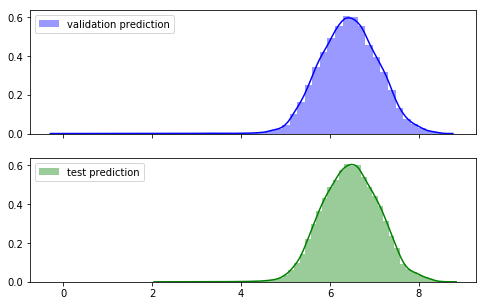

Total time: 3318 seconds


In [334]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['duration'] = np.exp(ytest)
test[['row_id', 'duration']].to_csv('yingying_submission_final.csv', index=False)

print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = dt.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)